#### Load the Dataset

In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_path ='/content/gdrive/MyDrive/ImageC/Testing/dataset'
directory_path='/content/gdrive/MyDrive/ImageC/Testing/pretrained'

In [ ]:
import random
import torch
import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VisionDataset
import os
import time
import matplotlib.pyplot as plt
from skimage import io, color
import numpy as np
import pandas as pd
import warnings
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import extract_archive, check_integrity, download_url, verify_str_arg

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-05-07 18:02:15--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.1’

tiny-imagenet-200.z 100%[===================>] 236.61M  7.67MB/s    in 39s     

2021-05-07 18:02:55 (6.04 MB/s) - ‘tiny-imagenet-200.zip.1’ saved [248100043/248100043]



In [ ]:
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

test  train  val  wnids.txt  words.txt


In [ ]:
# adopted from https://github.com/lvyilin/pytorch-fgvc-dataset/blob/master/tiny_imagenet.py
class TinyImageNet(VisionDataset):
    """`tiny-imageNet <http://cs231n.stanford.edu/tiny-imagenet-200.zip>`_ Dataset.
        Args:
            root (string): Root directory of the dataset.
            split (string, optional): The dataset split, supports ``train``, or ``val``.
            transform (callable, optional): A function/transform that  takes in an PIL image
               and returns a transformed version. E.g, ``transforms.RandomCrop``
            target_transform (callable, optional): A function/transform that takes in the
               target and transforms it.
            download (bool, optional): If true, downloads the dataset from the internet and
               puts it in root directory. If dataset is already downloaded, it is not
               downloaded again.
    """
    base_folder = 'tiny-imagenet-200/'
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    filename = 'tiny-imagenet-200.zip'
    md5 = '90528d7ca1a48142e341f4ef8d21d0de'

    def __init__(self, root, split='train', transform=None, target_transform=None, download=False, percent=0.1):
        super(TinyImageNet, self).__init__(root, transform=transform, target_transform=target_transform)

        self.dataset_path = os.path.join(root, self.base_folder)
        self.loader = default_loader
        self.split = verify_str_arg(split, "split", ("train", "val",))
        self.percent = percent
        '''
        if self._check_integrity():
            print('Files already downloaded and verified.')
        elif download:
            self._download()
        else:
            raise RuntimeError(
                'Dataset not found. You can use download=True to download it.')
        '''
        if not os.path.isdir(self.dataset_path):
            print('Extracting...')
            extract_archive(os.path.join(root, self.filename))

        _, class_to_idx = find_classes(os.path.join(self.dataset_path, 'wnids.txt'))

        self.data = make_dataset(self.root, self.base_folder, self.split, class_to_idx, self.percent)

    def _download(self):
        print('Downloading...')
        download_url(self.url, root=self.root, filename=self.filename)
        print('Extracting...')
        extract_archive(os.path.join(self.root, self.filename))

    def _check_integrity(self):
        return check_integrity(os.path.join(self.root, self.filename), self.md5)

    def __getitem__(self, index):
        img_path, target = self.data[index]
        image = self.loader(img_path)

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.data)


def find_classes(class_file):
    with open(class_file) as r:
        classes = list(map(lambda s: s.strip(), r.readlines()))

    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}

    return classes, class_to_idx


def make_dataset(root, base_folder, dirname, class_to_idx, percent=1):
    images = []
    dir_path = os.path.join(root, base_folder, dirname)

    if dirname == 'train':
        for fname in sorted(os.listdir(dir_path)):
            cls_fpath = os.path.join(dir_path, fname)
            if os.path.isdir(cls_fpath):
                cls_imgs_path = os.path.join(cls_fpath, 'images')
                image_names = os.listdir(cls_imgs_path)
                image_number = len(image_names)
                smaple_image_names = random.sample(image_names, int(image_number*percent))
                for imgname in sorted(smaple_image_names):
                    path = os.path.join(cls_imgs_path, imgname)
                    item = (path, class_to_idx[fname])
                    images.append(item)
    else:
        imgs_path = os.path.join(dir_path, 'images')
        imgs_annotations = os.path.join(dir_path, 'val_annotations.txt')

        with open(imgs_annotations) as r:
            data_info = map(lambda s: s.split('\t'), r.readlines())

        cls_map = {line_data[0]: line_data[1] for line_data in data_info}
        image_names = os.listdir(imgs_path)
        image_number = len(image_names)
        smaple_image_names = random.sample(image_names, int(image_number*percent))
        for imgname in smaple_image_names:
            path = os.path.join(imgs_path, imgname)
            item = (path, class_to_idx[cls_map[imgname]])
            images.append(item)

    return images

In [ ]:
norm = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# data augmentation to training data
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), norm])
test_transform = transforms.Compose([transforms.ToTensor(), norm])

In [ ]:
train_dataset = TinyImageNet('.', split='train', download=False, transform=train_transform, percent = 0.1)
val_dataset = TinyImageNet('.', split='val', download=False, transform=test_transform)
# test_dataset = TinyImageNet('.', split='test', download=False, transform=test_transform)

In [ ]:
batch_size=128
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,  shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True)

print(len(val_dataset))
print(len(train_dataset))

1000
10000


In [ ]:
for image, label in train_dataset:
  print(image.shape)
  break

torch.Size([3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([190,  64, 173,  68,  36,  56,  47, 182, 191,  23, 126,  89, 123,  78,
         50,  82, 103,  69, 197, 173,  43,   0, 181,  55,  35, 179,  17, 175,
        131, 159,   8,  10,  44,  87,  32, 115,  58, 101, 104,   9,  68,  10,
         47, 170,  58,  23, 164, 181, 155,   5, 115,  53,  48, 176,  64, 177,
         52,  52,  62,  43, 176, 132, 151,   0,  46, 109,  31,  76,   7, 100,
        103,  35,  42,  59, 101,  68,  20,  69,  67,  24, 187, 189, 186, 127,
         15, 113, 139, 153, 165, 187, 108, 158, 188,  86, 162,  50,  49, 122,
         28,  39, 154,  61,  21, 105, 174,  56, 169, 150,  48, 154, 194, 133,
         12, 119, 127,  61,  13,  83, 196,  51,  85,  16, 181,  74, 133,  96,
        172, 152])


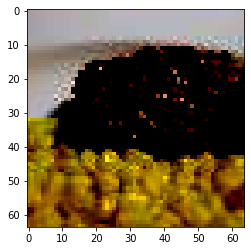

In [ ]:
for image, label in train_dataloader:
  print(label)
  plt.imshow(image[0].permute(1, 2, 0))
  break

#### Load the Model

In [ ]:
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50
# from torchvision.models.utils import load_state_dict_from_url


class Model(nn.Module):
    def __init__(self, feature_dim=128):
        super(Model, self).__init__()

        self.f = []
        for name, module in resnet50().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.f = nn.Sequential(*self.f)
        # projection head
        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)

class encoderModel(nn.Module):
    def __init__(self, feature_dim=128):
        super(encoderModel, self).__init__()

        self.f = []
        for name, module in resnet50().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.f = nn.Sequential(*self.f)
        self.fc = nn.Linear(2048, 200)

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        x = self.fc(feature)
        return x

def simclr_encoder(path='/content/gdrive/MyDrive/ImageC/Entire-Dataset/simclr_entire.pth'):
    model = encoderModel()
    state_dict = torch.load(path)
    model.load_state_dict(state_dict, strict=False)
    for name, module in model.named_children():
        if name=='fc':
            for param in module.parameters():
                param.requires_grad = True
        else:
            for param in module.parameters():
                param.requires_grad = False
    return model
# print(model)



In [ ]:
model = simclr_encoder()

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).cpu().data.item())
    return res

In [ ]:
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in val_dataloader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        # images = images.view(-1, 64*64)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    prec1, prec5 = accuracy(outputs.data, labels, topk=(1, 5))

    return prec1, prec5, loss_sum / total

In [ ]:
def train(net,
          optimizer,
          loss_metric,
          scheduler,
          epochs = 10,
          load_model_path = None,
          save_model_name = 'resnet-tiny-10-baseline.pth',
          save_data_name = 'resnet-tiny-10-baseline_data.npz'
          ):
  
  if load_model_path:
    print('load trained model')
    state_dict = torch.load(load_model_path)
    net.load_state_dict(state_dict)

  #define batch train loss recording array for later visualization/plotting:
  loss_store = []
  train_perc1_store = []
  train_perc5_store = []
  test_perc1_store = [] 
  test_perc5_store = []
  test_loss_store = []
  best_test_perc = 0
  print("Starting Training")
  #training loop:
  for epoch in range(epochs):
      time1 = time.time() #timekeeping

      net.train()
      total = 0
      correct = 0
      train_loss = 0
      for i, (x,y) in enumerate(train_dataloader):

          if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

          # x = x.view(x.shape[0],-1)
          #loss calculation and gradient update:

          if i > 0 or epoch > 0:
              optimizer.zero_grad()
          outputs = net.forward(x)
          train_prec1, train_prec5 = accuracy(outputs.data, y, topk=(1, 5))
          _, predicted = torch.max(outputs.data, 1)
          total += y.size(0)
          
          correct += (predicted.float() == y.float()).sum()
          loss = loss_metric(outputs,y)
          train_loss += loss.cpu().data.numpy().item()
          loss.backward()

          ##perform update:
          optimizer.step()

      print("Epoch",epoch+1,':')
      # train
      print('Train accuracy 1: %f %%' % train_prec1)
      print('Train accuracy 5: %f %%' % train_prec5)
      print('Train loss: %f' % (train_loss/total))
      loss_store.append(train_loss/total)
      train_perc1_store.append(train_prec1)
      train_perc5_store.append(train_prec5)
      
      net.eval()
      # test    
      prec1, prec5, loss = test_eval()
      test_loss_store.append(loss)
      test_perc1_store.append(prec1)
      test_perc5_store.append(prec5)
      print('test accuracy 1: %f %%' % prec1)
      print('test accuracy 5: %f %%' % prec5)
      print('test loss: %f' % loss)
      # save the model with highest acc on test set
      if prec1 > best_test_perc:
        best_test_perc = prec1
        torch.save(net.state_dict(), os.path.join(directory_path, save_model_name ))
        print('new best test acc at', epoch+1)

      scheduler.step()
      time2 = time.time() #timekeeping
      print('Elapsed time for epoch:',time2 - time1,'s')
      print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
      print()

      # save data
      save_filename = os.path.join(directory_path, save_data_name)
      np.savez(save_filename, train_perc1=train_perc1_store,  train_perc5=train_perc5_store, train_loss=loss_store, test_perc1=test_perc1_store, test_perc5=test_perc5_store, test_loss=test_loss_store)


#### Number of 10 Epochs

In [ ]:
## Get Model
net = model
if torch.cuda.is_available:
  net = net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
train_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.975) 
loss_metric = torch.nn.CrossEntropyLoss()
train(net,
      optimizer,
      loss_metric,
      train_scheduler,
      epochs = 10,
      save_model_name = 'simclr_entire.pth',
      save_data_name = 'simclr_entire_data.pth'
      )

Starting Training
Epoch 1 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 0.000000 %
Train loss: 0.041889
Test accuracy: 1.000000 %
Test loss: 0.042122
test accuracy 1: 0.000000 %
test accuracy 5: 2.884615 %
test loss: 0.042122
Elapsed time for epoch: 28.540274143218994 s
ETA of completion: 4.281041121482849 minutes

Epoch 2 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 6.250000 %
Train loss: 0.041711
Test accuracy: 1.900000 %
Test loss: 0.042118
test accuracy 1: 0.961538 %
test accuracy 5: 2.884615 %
test loss: 0.042118
new best test acc at 2
Elapsed time for epoch: 30.675520420074463 s
ETA of completion: 4.090069389343261 minutes

Epoch 3 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 0.000000 %
Train loss: 0.041612
Test accuracy: 1.000000 %
Test loss: 0.041843
test accuracy 1: 0.961538 %
test accuracy 5: 3.846154 %
test loss: 0.041843
Elapsed time for epoch: 28.599117755889893 s
ETA of completion: 3.336563738187154 minutes

Epoch 4 :
Train accuracy 1: 6.250000 %
Train accuracy

#### Number of 50 Epochs

In [ ]:
## Get Model
model = simclr_encoder()
net = model
if torch.cuda.is_available:
  net = net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
train_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.975) 
loss_metric = torch.nn.CrossEntropyLoss()
train(net,
      optimizer,
      loss_metric,
      train_scheduler,
      epochs = 50,
      save_model_name = 'simclr_entire.pth',
      save_data_name = 'simclr_entire_data2.pth'
      )

Starting Training
Epoch 1 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 0.000000 %
Train loss: 0.042075
Test accuracy: 0.900000 %
Test loss: 0.042069
test accuracy 1: 0.961538 %
test accuracy 5: 3.846154 %
test loss: 0.042069
new best test acc at 1
Elapsed time for epoch: 28.949536561965942 s
ETA of completion: 23.64212152560552 minutes

Epoch 2 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 6.250000 %
Train loss: 0.041854
Test accuracy: 1.400000 %
Test loss: 0.042120
test accuracy 1: 1.923077 %
test accuracy 5: 2.884615 %
test loss: 0.042120
new best test acc at 2
Elapsed time for epoch: 29.047152042388916 s
ETA of completion: 23.237721633911132 minutes

Epoch 3 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 0.000000 %
Train loss: 0.041681
Test accuracy: 0.900000 %
Test loss: 0.041938
test accuracy 1: 1.923077 %
test accuracy 5: 4.807692 %
test loss: 0.041938
Elapsed time for epoch: 28.49957823753357 s
ETA of completion: 22.324669619401295 minutes

Epoch 4 :
Train accuracy 1: 0

#### Number of 100 Epochs

In [ ]:
## Get Model
model = simclr_encoder()
net = model
if torch.cuda.is_available:
  net = net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
train_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.975) 
loss_metric = torch.nn.CrossEntropyLoss()
train(net,
      optimizer,
      loss_metric,
      train_scheduler,
      epochs = 100,
      save_model_name = 'simclr_entire.pth',
      save_data_name = 'simclr_entire_data3.pth'
      )

Starting Training
Epoch 1 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 6.250000 %
Train loss: 0.047982
Test accuracy: 0.300000 %
Test loss: 0.054560
test accuracy 1: 0.000000 %
test accuracy 5: 1.923077 %
test loss: 0.054560
Elapsed time for epoch: 28.483517169952393 s
ETA of completion: 46.99780333042145 minutes

Epoch 2 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 6.250000 %
Train loss: 0.049809
Test accuracy: 0.700000 %
Test loss: 0.050966
test accuracy 1: 0.000000 %
test accuracy 5: 1.923077 %
test loss: 0.050966
Elapsed time for epoch: 28.53367042541504 s
ETA of completion: 46.604995028177896 minutes

Epoch 3 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 0.000000 %
Train loss: 0.048930
Test accuracy: 0.600000 %
Test loss: 0.051139
test accuracy 1: 0.000000 %
test accuracy 5: 0.000000 %
test loss: 0.051139
Elapsed time for epoch: 28.50494146347046 s
ETA of completion: 46.082988699277244 minutes

Epoch 4 :
Train accuracy 1: 0.000000 %
Train accuracy 5: 6.250000 %
Train lo

#### Visualization

In [ ]:
def plot_data(filepath):
    data = np.load(filepath)

    if 'train_perc' in data:
        plt.plot(data['train_perc'], '-o',label = 'train precision')
        plt.xlabel('epoch Number')
    if 'test_perc' in data:
        plt.plot(data['test_perc'], '-o', label = 'validation precision')
        plt.xlabel('epoch Number')
    plt.ylabel('train/val precision at each epoch')
    plt.legend()
    plt.show()

    if 'train_loss' in data:
        plt.plot(data['train_loss'], '-o', label = 'train loss')
        plt.xlabel('epoch Number')
    if 'test_loss' in data:
        plt.plot(data['test_loss'], '-o', label = 'validation loss')
        plt.xlabel('epoch Number')
    plt.ylabel('train/val loss at each epoch')
    plt.legend()
    plt.show()

In [ ]:
def plot_data(filepath):
    data = np.load(filepath)

    if 'train_perc' in data:
        plt.plot(data['train_perc'],label = 'train precision')
        plt.xlabel('epoch Number')
    plt.ylabel('train/val precision at each epoch')
    plt.legend()
    plt.show()    
    if 'test_perc' in data:
        plt.plot(data['test_perc'], label = 'validation precision')
        plt.xlabel('epoch Number')
    plt.ylabel('train/val precision at each epoch')
    plt.legend()
    plt.show()

    if 'train_loss' in data:
        plt.plot(data['train_loss'], label = 'train loss')
        plt.xlabel('epoch Number')
    if 'test_loss' in data:
        plt.plot(data['test_loss'], label = 'validation loss')
        plt.xlabel('epoch Number')
    plt.ylabel('train/val loss at each epoch')
    plt.legend()
    plt.show()

In [ ]:
print("Number of 10 Epochs")
plot_data(directory_path+'/simclr_entire_data.pth.npz')

In [ ]:
print("Number of 50 Epochs")
plot_data(directory_path+'/simclr_entire_data2.pth.npz')

In [ ]:
print("Number of 100 Epochs")
plot_data(directory_path+'/simclr_entire_data3.pth.npz')